#Music Genre and Composer Classification Using Deep Learning

**Introduction**
Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.

**Dataset**
The project will use a dataset consisting of musical scores from various composers. The  dataset contains MIDI files of compositions from well-known classical composers like Bach, Beethoven, Chopin, Mozart, Schubert, etc. (9 composers).


**Objective**
The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two approaches.

1.   The first approach involves converting the MIDI files to WAV files and feature extraction using MFCCs,Mel-Spectograms,Chroma vector and Tonnetz from each audio file and using deep neural networks to do the classification.

2.  The second approach involves feature extraction from raw MIDI files. The feature list includes the following

The estimated tempo (beats per minute) of the MIDI file.

The number of time signature changes in the MIDI file.

The resolution of the MIDI file.

The numerator of the time signature (e.g., 4 in 4/4 time)
of the MIDI file. If no time signature changes are present, it defaults to 4.

The denominator of the time signature (e.g., 4 in 4/4 time) of the MIDI file. If no time signature changes are present, it defaults to 4.

The number of different instruments used in the MIDI file.

Note Distribution: Number of notes (total count of MIDI notes in the file).

Average note pitch (average MIDI note number).

Range of note pitches (highest MIDI note number - lowest MIDI note number).

Standard deviation of note pitches (measure of pitch variation).
Note density (number of notes per unit of time).

3. Approach 3 : Using XGBoost model to perform classification on the extracted feature list in Approach 2.

4. Approach 4 : Using pretty_midi , we extract the piano roll representation for each midi files. And we trained a CNN classification network.

5. Approach 5 : Using pretrained model Wave2Vec model to have the feature embeddings for each audio file for all the classes to fine tune a deep neural network to perform classification(freezing the layers of the pretrained model.)






In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 5.1 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592285 sha256=5f7dd72b4217b99ffc34fbac04dda52e1af86388f725e25bd75490b12c33e286
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
import zipfile

zip_file = "Composer_Dataset.zip"
output_folder = "unzipped_data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print("File unzipped successfully!")


File unzipped successfully!


In [ ]:
#@title Importing the required libraries
import numpy as np
import pandas as pd
import os
import glob
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import pretty_midi
import csv
import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
import librosa
import librosa.display

### Data Loading

In [ ]:
# Function to load MIDI files from a directory using PrettyMIDI (AI Generated Music)
def load_midi_files(data_dir):
    all_files = glob.glob(os.path.join(data_dir, '*/*.mid'))  # get all .mid files in the data_dir
    data = []
    for file in all_files:
        try:
            midi_file = pretty_midi.PrettyMIDI(file)  # load MIDI file
            data.append((os.path.basename(os.path.dirname(file)), midi_file))  # add composer (folder name) and midi file
        except (IOError, pretty_midi.exceptions.StandardError):
            pass  # some MIDI files may be corrupted or not standard MIDI, so skip these
    return data


In [ ]:
midi_folder = "/content/unzipped_data/Composer_Dataset/NN_midi_files_extended/dev/bach/"
output_csv = "midi_analysis.csv"

In [ ]:
#@title Set new ly created data set
df = pd.read_csv('midi_analysis.csv')
df.head(3)

,File,Note,Start Time,End Time
0,bach354.mid,72,0.546875,0.770833
1,bach354.mid,72,1.515625,1.997396
2,bach354.mid,72,2.000000,2.223958


In [ ]:
# Load the data from each training, test, and dev folder
train_data = load_midi_files('./Composer_Dataset/NN_midi_files_extended/train/')  # load the data
test_data = load_midi_files('./Composer_Dataset/NN_midi_files_extended/test/')  # load the data
dev_data = load_midi_files('./Composer_Dataset/NN_midi_files_extended/dev/')  # load the data

# Verify that the data was loaded correctly
print('Number of training examples: ', len(train_data))
print('Number of test examples: ', len(test_data))
print('Number of dev examples: ', len(dev_data))

Number of training examples:  0
Number of test examples:  0
Number of dev examples:  0


### Data Exploration

In [ ]:
#@title Plot 3D graph of csv file
z_data = df
fig = go.Figure(data=[go.Surface(z=z_data.values)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

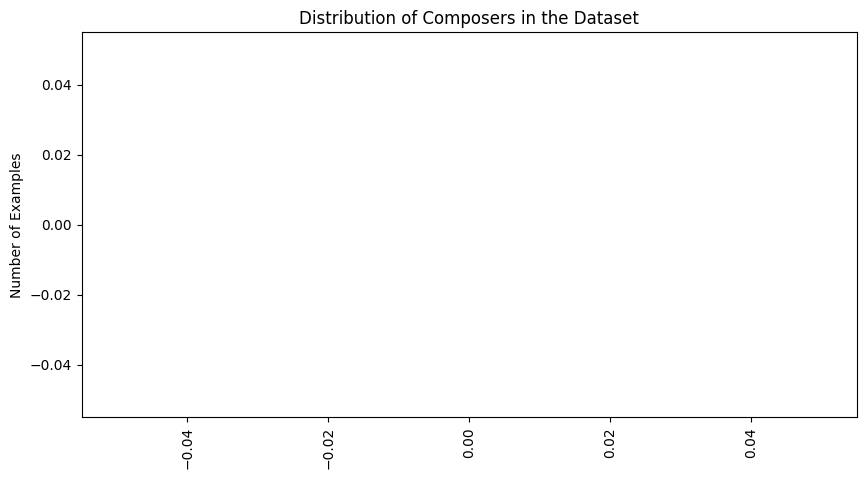

In [ ]:
# Plot the distribution of composers in the dataset for the training set
from collections import Counter

def plot_composer_distribution(data):
    composer_names = [name for name, _ in data]
    composer_counts = Counter(composer_names)

    plt.figure(figsize=(10, 5))
    plt.bar(composer_counts.keys(), composer_counts.values())
    plt.title('Distribution of Composers in the Dataset')
    plt.ylabel('Number of Examples')
    plt.xticks(rotation='vertical')
    plt.show()

# Plot
plot_composer_distribution(train_data)


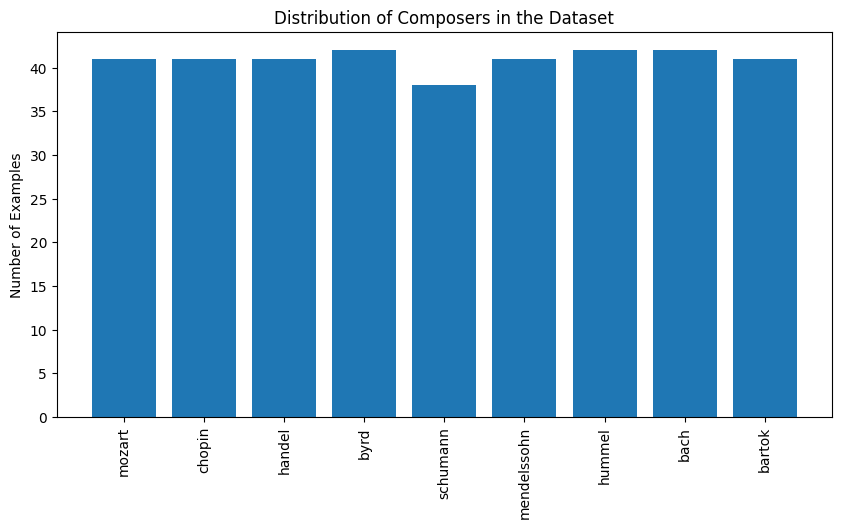

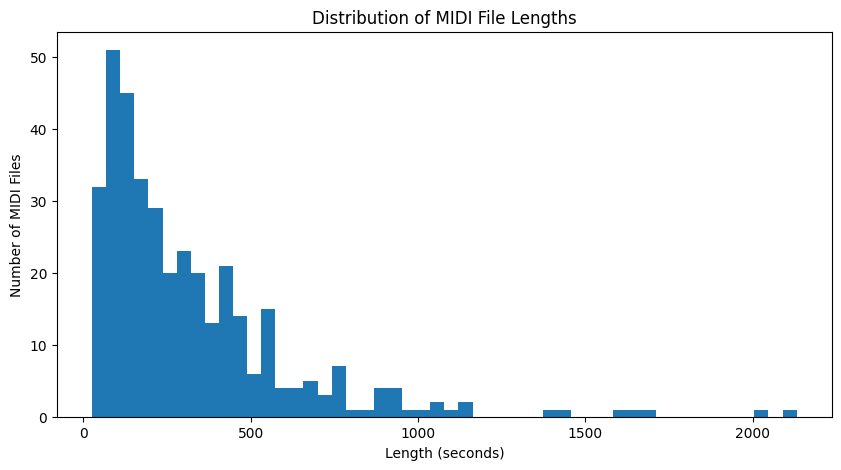

In [ ]:
# Plot the distribution for the length of the MIDI files in the training data
def plot_length_distribution(data):
    lengths = [midi_file.get_end_time() for _, midi_file in data]

    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=50)
    plt.title('Distribution of MIDI File Lengths')
    plt.xlabel('Length (seconds)')
    plt.ylabel('Number of MIDI Files')
    plt.show()

# Plot
plot_length_distribution(train_data)


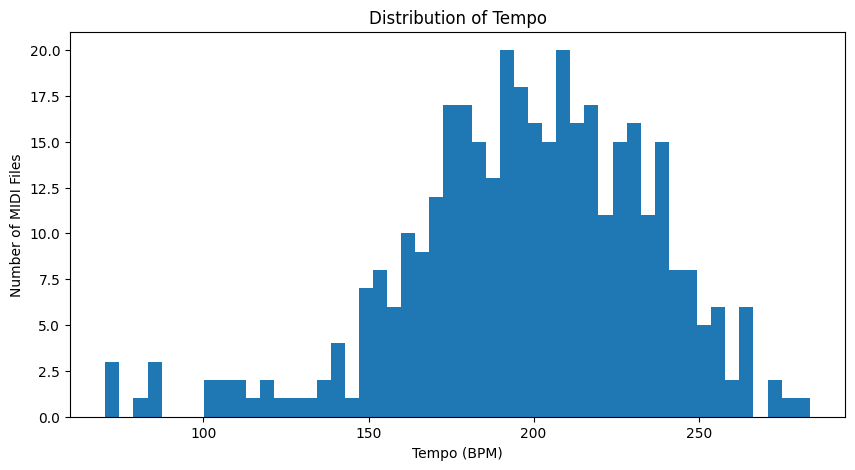

In [ ]:
# Plot the distribution of tempos in the training data
def plot_tempo_distribution(data):
    tempos = [midi_file.estimate_tempo() for _, midi_file in data]

    plt.figure(figsize=(10, 5))
    plt.hist(tempos, bins=50)
    plt.title('Distribution of Tempo')
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Number of MIDI Files')
    plt.show()

# Plot
plot_tempo_distribution(train_data)


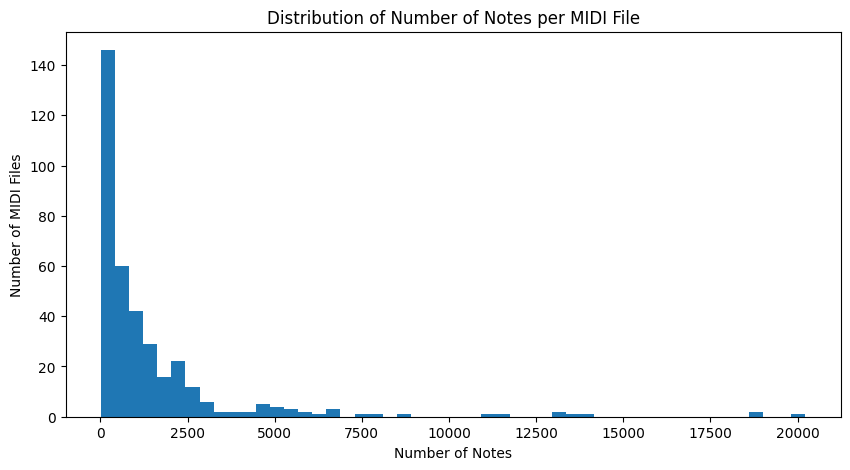

In [ ]:
# Plot the distribution of number of notes in the training data
def plot_notes_distribution(data):
    num_notes = [len(midi_file.instruments[0].notes) for _, midi_file in data]

    plt.figure(figsize=(10, 5))
    plt.hist(num_notes, bins=50)
    plt.title('Distribution of Number of Notes per MIDI File')
    plt.xlabel('Number of Notes')
    plt.ylabel('Number of MIDI Files')
    plt.show()

# Plot
plot_notes_distribution(train_data)


In [ ]:
def plot_piano_roll_for_instruments(midi_data, instrument_names):
    for instrument_name in instrument_names:
        for instrument in midi_data.instruments:
            if instrument.program == pretty_midi.instrument_name_to_program(instrument_name):
                piano_roll = instrument.get_piano_roll(fs=10)
                break
        else:
            print(f"{instrument_name} not found in this MIDI file.")
            continue

        plt.figure(figsize=(12, 4))
        librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(24), hop_length=1, sr=10)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'{instrument_name}')
        plt.tight_layout()
        plt.show()


/var/folders/8t/_x4qcscx7txf2l7h7tx1jwgr0000gn/T/ipykernel_8349/877155913.py:12: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(24), hop_length=1, sr=10)


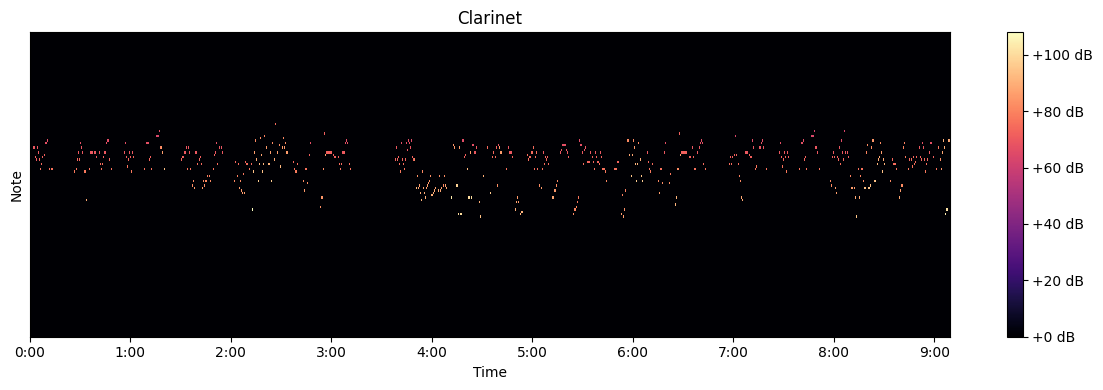

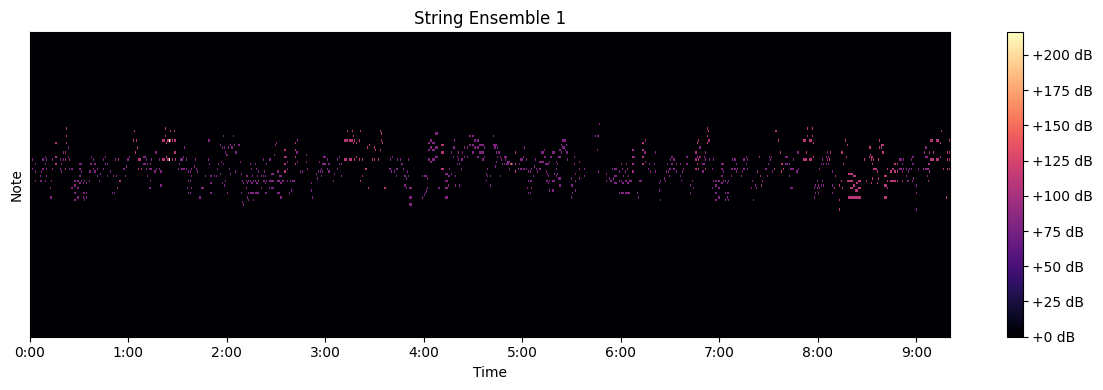

In [ ]:
# Plot for instruments listed
instruments = get_instruments(train_data[0][1])
plot_piano_roll_for_instruments(train_data[0][1], instruments)


   Preprocessing the raw midi files to wav files and extracting the MFCCs, mel spectograms , Chroma vectors and tonnetz  .



In [ ]:
# Loading the dataset
file_path = '/content/test.csv'
data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset
data.head()

,Tempo,NumSigChanges,Resolution,TS_Num,TS_Den,NumInstruments,NumNotes,AvgNotePitch,NotePitchRange,NotePitchStd,NoteDensity,composer
0,256.177863,1,384,3,8,4,8465,65.176610,62,12.111624,16.083238,mozart
1,252.578646,1,384,4,4,2,2977,67.771246,53,10.328322,10.749957,mozart
2,164.921515,1,384,6,8,6,2079,63.681097,57,11.459227,4.912413,mozart
3,229.335940,1,384,3,4,4,5076,67.565406,58,11.051132,11.233172,mozart
4,206.769877,1,240,3,8,3,1171,66.806149,62,7.693143,19.133987,schumann


In [ ]:
# Checking for missing values in the dataset
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

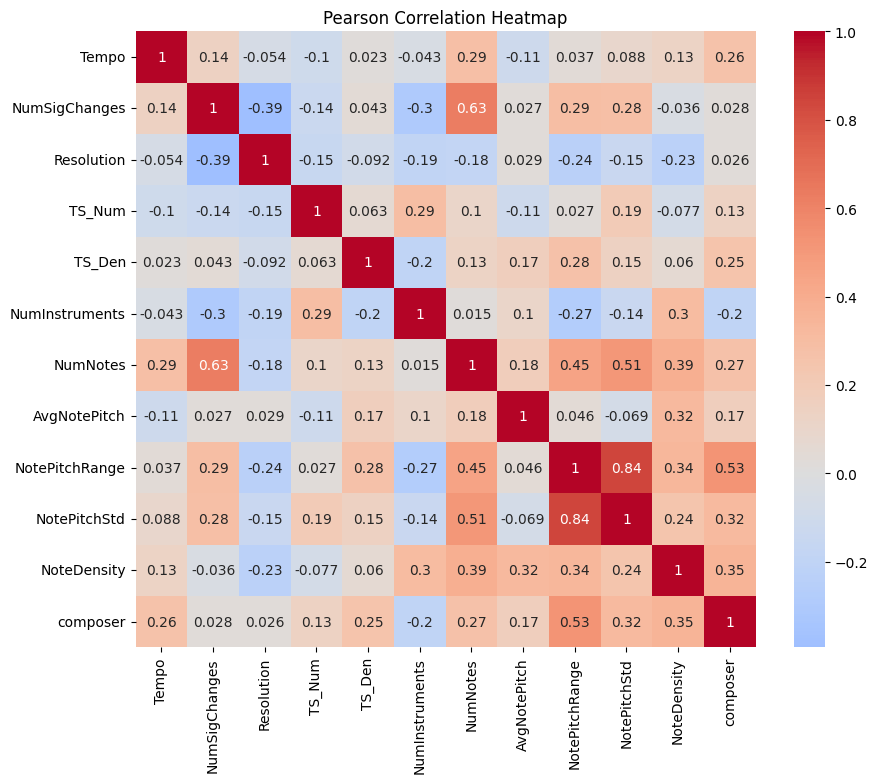

,Tempo,NumSigChanges,Resolution,TS_Num,TS_Den,NumInstruments,NumNotes,AvgNotePitch,NotePitchRange,NotePitchStd,NoteDensity,composer
Tempo,1.000000,0.141205,-0.054331,-0.102738,0.022615,-0.042590,0.285938,-0.110227,0.036886,0.088003,0.132882,0.261665
NumSigChanges,0.141205,1.000000,-0.394031,-0.135148,0.042930,-0.298166,0.628963,0.026682,0.294346,0.282940,-0.036002,0.028236
Resolution,-0.054331,-0.394031,1.000000,-0.149473,-0.091812,-0.190034,-0.178507,0.029223,-0.237781,-0.146329,-0.227327,0.026459
TS_Num,-0.102738,-0.135148,-0.149473,1.000000,0.062617,0.288227,0.104054,-0.109201,0.027370,0.194638,-0.076794,0.134300
TS_Den,0.022615,0.042930,-0.091812,0.062617,1.000000,-0.201689,0.127590,0.169835,0.275715,0.146402,0.060198,0.250622
NumInstruments,-0.042590,-0.298166,-0.190034,0.288227,-0.201689,1.000000,0.015006,0.102704,-0.269025,-0.139205,0.303717,-0.203249
NumNotes,0.285938,0.628963,-0.178507,0.104054,0.127590,0.015006,1.000000,0.175122,0.446157,0.513016,0.387482,0.268965
AvgNotePitch,-0.110227,0.026682,0.029223,-0.109201,0.169835,0.102704,0.175122,1.000000,0.045512,-0.069327,0.321985,0.170953
NotePitchRange,0.036886,0.294346,-0.237781,0.027370,0.275715,-0.269025,0.446157,0.045512,1.000000,0.842526,0.337567,0.526724
NotePitchStd,0.088003,0.282940,-0.146329,0.194638,0.146402,-0.139205,0.513016,-0.069327,0.842526,1.000000,0.243639,0.317157


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Encoding the target variable 'composer'
label_encoder = LabelEncoder()
data['composer'] = label_encoder.fit_transform(data['composer'])

# Find the pearson correlations matrix
corr = data.corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Pearson Correlation Heatmap")
plt.show()
corr

Approach 1:  Data Pre-processing

In [ ]:
# Function to convert the midi files to wav
!pip3 install midi2audio
from midi2audio import FluidSynth

def midi_to_wav(midi_file_path, wav_file_path):
    fs = FluidSynth('/usr/local/Cellar/fluid-synth/2.3.3/share/soundfonts/GeneralUser GS MuseScore v1.442.sf2')
    fs.midi_to_audio(midi_file_path, wav_file_path)

def convert_all_midi_to_wav(input_dir, output_dir):
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.mid'):
                # Get the full path to the MIDI file
                input_file = os.path.join(root, file)

                # Create a corresponding path in the output directory
                output_file = os.path.join(output_dir, os.path.relpath(input_file, input_dir))
                output_file = os.path.splitext(output_file)[0] + '.wav'

                # Check if the output WAV file already exists
                if os.path.exists(output_file):
                    print(f'{output_file} already exists, skipping...')
                    continue

                # Ensure the output directory exists
                os.makedirs(os.path.dirname(output_file), exist_ok=True)

                # Convert the MIDI file to a WAV file
                print(f'Converting {input_file} to {output_file}...')
                midi_to_wav(input_file, output_file)


In [ ]:
# Convert the MIDI files to WAV files

# Set the directories for the MIDI and WAV files
base_midi_data_dir = './Composer_Dataset/NN_midi_files_extended/'
base_wav_data_dir = 'wav/'

# List of main directories like -dev, -test, -train
main_dirs = ['dev', 'test', 'train']

for main_dir in main_dirs:
    midi_data_dir = os.path.join(base_midi_data_dir, main_dir)
    wav_data_dir = os.path.join(base_wav_data_dir, f"{main_dir}")

    # Get all composer directories
    composer_dirs = os.listdir(midi_data_dir)

    # Create a new WAV directory for each composer
    for composer in composer_dirs:
        composer_midi_dir = os.path.join(midi_data_dir, composer)
        composer_wav_dir = os.path.join(wav_data_dir, composer)

        # Convert all MIDI files in this composer's directory to WAV
        convert_all_midi_to_wav(composer_midi_dir, composer_wav_dir)


wav/dev/mozart/mozart039.wav already exists, skipping...
wav/dev/mozart/mozart035.wav already exists, skipping...
wav/dev/mozart/mozart020.wav already exists, skipping...
wav/dev/mozart/mozart040.wav already exists, skipping...
wav/dev/chopin/chopin069.wav already exists, skipping...
wav/dev/chopin/chopin087.wav already exists, skipping...
wav/dev/chopin/chopin061.wav already exists, skipping...
wav/dev/chopin/chopin070.wav already exists, skipping...
wav/dev/handel/handel106.wav already exists, skipping...
wav/dev/handel/handel139.wav already exists, skipping...
wav/dev/handel/handel145.wav already exists, skipping...
wav/dev/handel/handel119.wav already exists, skipping...
wav/dev/byrd/byrd180.wav already exists, skipping...
wav/dev/byrd/byrd168.wav already exists, skipping...
wav/dev/byrd/byrd184.wav already exists, skipping...
wav/dev/byrd/byrd152.wav already exists, skipping...
wav/dev/schumann/schumann217.wav already exists, skipping...
wav/dev/schumann/schumann238.wav already ex

In [ ]:
# Sanity check to make sure that all MIDI files have corresponding WAV files
def verify_midi_wav_match(midi_dir, wav_dir):
    # List all midi and wav files
    midi_files = [f for f in os.listdir(midi_dir) if f.endswith('.mid')]
    wav_files = [f for f in os.listdir(wav_dir) if f.endswith('.wav')]

    # Strip extensions for comparison
    midi_names = {os.path.splitext(f)[0] for f in midi_files}
    wav_names = {os.path.splitext(f)[0] for f in wav_files}

    missing_wav_files = midi_names - wav_names
    extra_wav_files = wav_names - midi_names

    if not missing_wav_files and not extra_wav_files:
        print("All files are accounted for/matching.")
    else:
        if missing_wav_files:
            print("Missing WAV files for these MIDI files:")
            for name in missing_wav_files:
                print(name + ".mid")
            print()

        if extra_wav_files:
            print("Extra WAV files (not corresponding to any MIDI):")
            for name in extra_wav_files:
                print(name + ".wav")


base_midi_data_dir = './Composer_Dataset/NN_midi_files_extended/'
base_wav_data_dir = 'wav/'

# List of main directories like -dev, -test, -train
main_dirs = ['dev', 'test', 'train']

for main_dir in main_dirs:
    midi_data_subdir = os.path.join(base_midi_data_dir, main_dir)
    wav_data_subdir = os.path.join(base_wav_data_dir, main_dir)

    # Only consider actual directories, filtering out files
    composer_dirs = [d for d in os.listdir(midi_data_subdir) if os.path.isdir(os.path.join(midi_data_subdir, d))]

    for composer in composer_dirs:
        composer_midi_dir = os.path.join(midi_data_subdir, composer)
        composer_wav_dir = os.path.join(wav_data_subdir, composer)

        print(f"Verifying for {composer}:")
        verify_midi_wav_match(composer_midi_dir, composer_wav_dir)
        print("------------------------------")


Verifying for mozart:
All files are accounted for/matching.
------------------------------
Verifying for chopin:
All files are accounted for/matching.
------------------------------
Verifying for handel:
All files are accounted for/matching.
------------------------------
Verifying for byrd:
All files are accounted for/matching.
------------------------------
Verifying for schumann:
All files are accounted for/matching.
------------------------------
Verifying for mendelssohn:
All files are accounted for/matching.
------------------------------
Verifying for hummel:
All files are accounted for/matching.
------------------------------
Verifying for bach:
All files are accounted for/matching.
------------------------------
Verifying for bartok:
All files are accounted for/matching.
------------------------------
Verifying for mozart:
All files are accounted for/matching.
------------------------------
Verifying for chopin:
All files are accounted for/matching.
---------------------------

## Feature Extraction

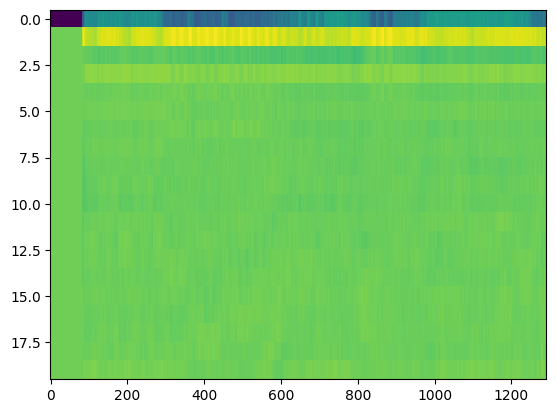

In [ ]:
# Visualization of MFCCs
def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc

test_file = 'wav/train/mozart/mozart000.wav'
mfcc = get_mfcc(test_file)
plt.imshow(mfcc, interpolation='nearest', aspect='auto')
plt.show()

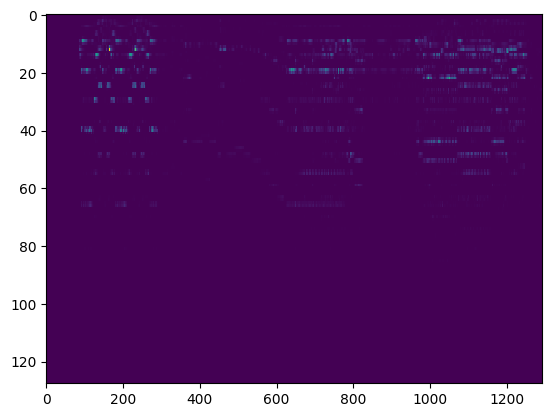

In [ ]:
# Visualization of the melspectrogram
def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

melspectrogram = get_melspectrogram(test_file)
plt.imshow(melspectrogram, interpolation='nearest', aspect='auto')
plt.show()

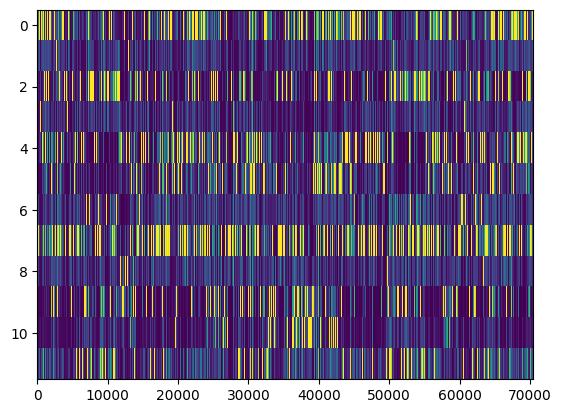

In [ ]:
# Visualization of chroma vector
def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

chroma = get_chroma_vector(test_file)
plt.imshow(chroma, interpolation='nearest', aspect='auto')
plt.show()

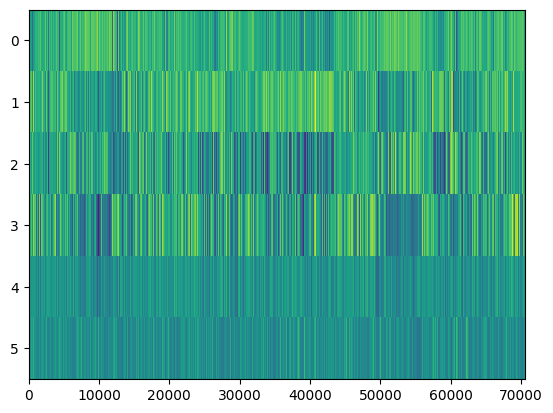

In [ ]:
# Visalization of the tonnetz feature
def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

tntz = get_tonnetz(test_file)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
# Function to extract each feature from audio file
# Lheureux A. (https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/)
def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = np.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(file_path)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = np.concatenate( (tntz_mean, tntz_min, tntz_max) )

  feature = np.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

In [ ]:
train_directory = 'wav/train'
dev_directory = 'wav/dev'
test_directory = 'wav/test'
composers = ['bach', 'bartok', 'byrd', 'chopin', 'handel', 'hummel', 'mendelssohn', 'mozart', 'schumann']

features_train, labels_train = [], []
features_dev, labels_dev = [], []
features_test, labels_test = [], []

directories = [(train_directory, features_train, labels_train),
               (dev_directory, features_dev, labels_dev),
               (test_directory, features_test, labels_test)]

for directory, features, labels in directories:
    for composer in composers:
        print(f"Calculating features for composer: {composer} in directory: {directory}")
        composer_path = os.path.join(directory, composer)
        for file in os.listdir(composer_path):
            file_path = os.path.join(composer_path, file)
            print(f"Processing {file_path}...")  # Print the file being processed

            try:
                features.append(get_feature(file_path))  # Assuming you have a function called get_feature
                label = composers.index(composer)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# shape
print("Train features shape:", np.array(features_train).shape)
print("Train labels shape:", np.array(labels_train).shape)

print("Dev features shape:", np.array(features_dev).shape)
print("Dev labels shape:", np.array(labels_dev).shape)

print("Test features shape:", np.array(features_test).shape)
print("Test labels shape:", np.array(labels_test).shape)



Calculating features for composer: bach in directory: wav/train
Processing wav/train/bach/bach389.wav...
Processing wav/train/bach/bach362.wav...
Processing wav/train/bach/bach377.wav...
Processing wav/train/bach/bach363.wav...
Processing wav/train/bach/bach388.wav...
Processing wav/train/bach/bach375.wav...
Processing wav/train/bach/bach361.wav...
Processing wav/train/bach/bach360.wav...
Processing wav/train/bach/bach374.wav...
Processing wav/train/bach/bach358.wav...
Processing wav/train/bach/bach370.wav...
Processing wav/train/bach/bach364.wav...
Processing wav/train/bach/bach365.wav...
Processing wav/train/bach/bach371.wav...
Processing wav/train/bach/bach367.wav...
Processing wav/train/bach/bach373.wav...
Processing wav/train/bach/bach372.wav...
Processing wav/train/bach/bach366.wav...
Processing wav/train/bach/bach380.wav...
Processing wav/train/bach/bach343.wav...
Processing wav/train/bach/bach357.wav...
Processing wav/train/bach/bach342.wav...
Processing wav/train/bach/bach381.

## Model Building

In [ ]:
# !pip3 install tensorflow

2023-08-07 10:01:28.149873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Build Model
# Lheureux A. (https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/)
# Define Input
inputs = keras.Input(shape=(498,), name="feature")

# Layer 1
x = keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)

# Layer 2
x = keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

# Output Layer
outputs = keras.layers.Dense(9, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(),
            #   metrics=[keras.metrics.SparseCategoricalAccuracy()])
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss')

# Convert the data to tensors
features_train_tensor = tf.convert_to_tensor(features_train)
labels_train_tensor = tf.convert_to_tensor(labels_train)

features_dev_tensor = tf.convert_to_tensor(features_dev)
labels_dev_tensor = tf.convert_to_tensor(labels_dev)

history = model.fit(
    x=features_train_tensor,
    y=labels_train_tensor,
    verbose=1,
    validation_data=(features_dev_tensor, labels_dev_tensor),
    epochs=300,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)



## Model Evaluation

In [ ]:
features_test_tensor = tf.convert_to_tensor(features_test)
labels_test_tensor = tf.convert_to_tensor(labels_test)

scores = model.evaluate(x=features_test_tensor, y=labels_test_tensor, verbose=1)
print('Loss:', scores[0])
print('Accuracy:', scores[1])

2/2 [==============================] - 0s 4ms/step - loss: 1.0977 - sparse_categorical_accuracy: 0.7429
[1.0977402925491333, 0.7428571581840515]
Test loss: 1.0977402925491333
Test accuracy: 0.7428571581840515


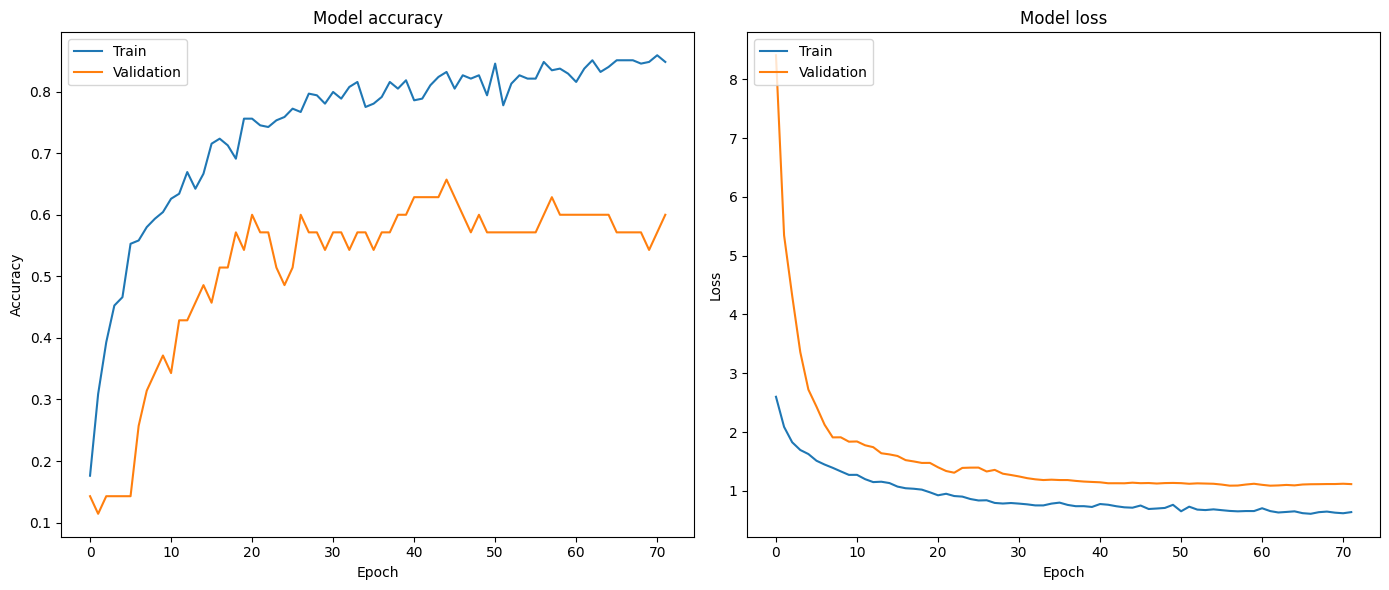

In [ ]:
#@title Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Approach 2:

Working with the raw MIDI files to extract music features.

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_dataset = "/content/drive/MyDrive/Composer_Dataset/NN_midi_files_extended/train/"
dev_dataset = "/content/drive/MyDrive/Composer_Dataset/NN_midi_files_extended/dev/"
test_dataset = "/content/drive/MyDrive/Composer_Dataset/NN_midi_files_extended/test/"

In [ ]:
def count_midi_files_in_subdirectories(directory):
    count = 0

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(".mid"):
                count += 1

    return count

train_midi_file_count = count_midi_files_in_subdirectories(train_dataset)
print(f"Number of MIDI files in train subdirectory: {train_midi_file_count}")

dev_midi_file_count = count_midi_files_in_subdirectories(dev_dataset)
print(f"Number of MIDI files in dev subdirectory: {dev_midi_file_count}")

test_midi_file_count = count_midi_files_in_subdirectories(test_dataset)
print(f"Number of MIDI files in test subdirectory: {test_midi_file_count}")

total = train_midi_file_count + dev_midi_file_count + test_midi_file_count
print(f"Total number of MIDI files: {total}")

Number of MIDI files in train subdirectory: 369
Number of MIDI files in dev subdirectory: 35
Number of MIDI files in test subdirectory: 35
Total number of MIDI files: 439


In [ ]:
def create_text_file(dataset,filename):
	info = []
	used = []
	track_id = 0
	for dir_name, subdir_list, file_list in os.walk(dataset):
		file_path_list = ['/'.join([dir_name, file]) for file in file_list if '.mid' in file]
		for file_path in file_list:
			if '.mid' not in file_path:
				continue
			track_id = ''.join([str(x) for x in file_path if x.isdigit()])
			composer = file_path[: -(len(track_id) + len('.mid'))]
			if track_id not in used:
				info.append((track_id, composer))
				used.append(track_id)
	with open(filename, "w") as f:
		for track_id, composer in info:
			f.write(track_id + '\t' + composer + '\n')


train_composers = create_text_file(train_dataset,"train_composers.txt")
dev_composers = create_text_file(dev_dataset,"dev_composers.txt")
test_composers = create_text_file(test_dataset,"test_composers.txt")



In [ ]:
def create_df(composers_txt):
	track_ids, composers = [], []
	with open(composers_txt) as f:
		while True:
			line = f.readline()
			if not line:
				break
			track_id, composer = line.strip('\n').split('\t')
			track_ids.append(track_id)
			composers.append(composer)
	return pd.DataFrame(data={"Composer": composers, "TrackID": track_ids})

train_df = create_df("train_composers.txt")
print(train_df.shape)
print(train_df.head())

dev_df = create_df("dev_composers.txt")
print(dev_df.shape)
print(dev_df.head())

test_df = create_df("test_composers.txt")
print(test_df.shape)
print(test_df.head())

(369, 2)
  Composer TrackID
0   mozart     021
1   mozart     008
2   mozart     010
3   mozart     046
4   mozart     024
(35, 2)
  Composer TrackID
0   mozart     039
1   mozart     020
2   mozart     035
3   mozart     040
4   chopin     061
(35, 2)
   Composer TrackID
0    mozart     025
1    mozart     038
2    mozart     014
3    mozart     004
4  schumann     220


In [ ]:
def load_midi_files_with_paths(path, composer_data):
	track_ids, midis = [], []
	for directory, composer, all_files in os.walk(path):
		files = [directory + '/' + file for file in all_files if '.mid' in file]
		for file in files:
			track_id = ''.join([str(x) for x in file if x.isdigit()])
			track_ids.append(track_id)
			midis.append(file)
	midi_data = pd.DataFrame({"TrackID": track_ids, "Path": midis})

	result_df = pd.merge(midi_data, composer_data, on='TrackID', how='inner')
	return result_df.drop(["TrackID"], axis=1)

train_df = load_midi_files_with_paths(train_dataset,train_df)
print(train_df.shape)
print(train_df.head())

dev_df = load_midi_files_with_paths(dev_dataset,dev_df)
print(dev_df.shape)
print(dev_df.head())

test_df = load_midi_files_with_paths(test_dataset,test_df)
print(test_df.shape)
print(test_df.head())



(369, 2)
                                                Path Composer
0  /content/drive/MyDrive/Composer_Dataset/NN_mid...   mozart
1  /content/drive/MyDrive/Composer_Dataset/NN_mid...   mozart
2  /content/drive/MyDrive/Composer_Dataset/NN_mid...   mozart
3  /content/drive/MyDrive/Composer_Dataset/NN_mid...   mozart
4  /content/drive/MyDrive/Composer_Dataset/NN_mid...   mozart
(35, 2)
                                                Path  Composer
0  /content/drive/MyDrive/Composer_Dataset/NN_mid...  schumann
1  /content/drive/MyDrive/Composer_Dataset/NN_mid...  schumann
2  /content/drive/MyDrive/Composer_Dataset/NN_mid...  schumann
3  /content/drive/MyDrive/Composer_Dataset/NN_mid...    mozart
4  /content/drive/MyDrive/Composer_Dataset/NN_mid...    mozart
(35, 2)
                                                Path  Composer
0  /content/drive/MyDrive/Composer_Dataset/NN_mid...    mozart
1  /content/drive/MyDrive/Composer_Dataset/NN_mid...    mozart
2  /content/drive/MyDrive/Composer_D

<Axes: >

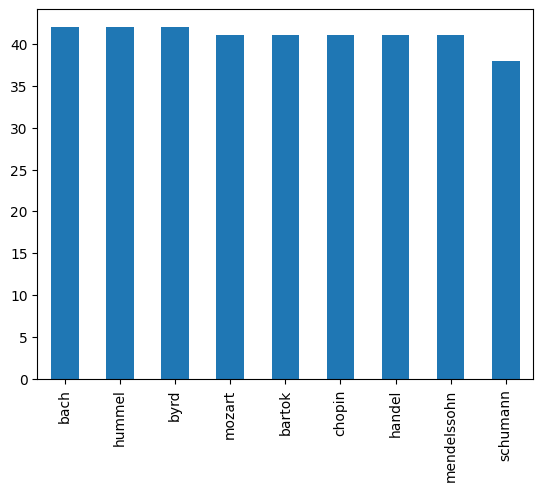

In [ ]:
# create a bar plot for Composer column

train_df.Composer.value_counts().plot(kind='bar')


<Axes: >

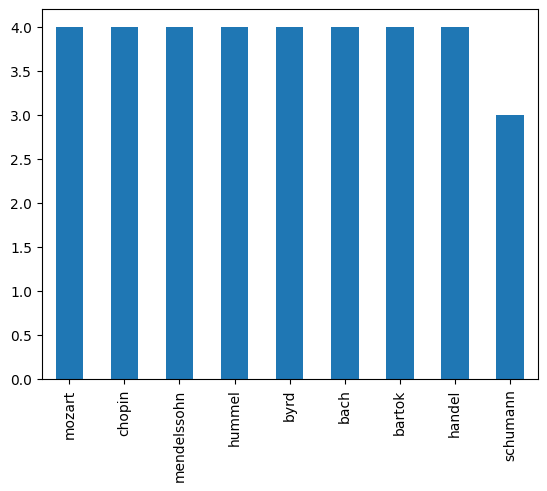

In [ ]:
dev_df.Composer.value_counts().plot(kind='bar')


<Axes: >

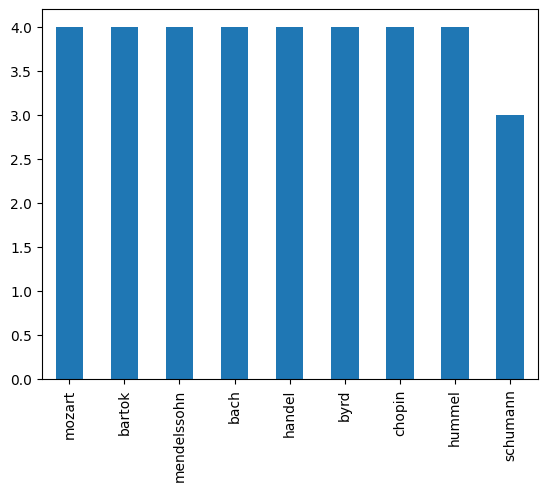

In [ ]:
test_df.Composer.value_counts().plot(kind='bar')


In [ ]:
# save the first row of the dataframe

first_row = train_df.iloc[0]
first_row.Path
# print(first_row[Path])

'/content/drive/MyDrive/Composer_Dataset/NN_midi_files_extended/train/mozart/mozart021.mid'

In [ ]:
#@title  Extract Features from Matched Midi Files
def extract_midi_features(file_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)

        # Extract features here
        tempo = midi_data.estimate_tempo()
        num_sig_changes = len(midi_data.time_signature_changes)
        resolution = midi_data.resolution
        ts_changes = midi_data.time_signature_changes
        ts_num = ts_changes[0].numerator if len(ts_changes) > 0 else 4
        ts_den = ts_changes[0].denominator if len(ts_changes) > 0 else 4
        instruments = midi_data.instruments
        num_instruments = len(instruments)
        # Note Distribution
        note_numbers = [note.pitch for instrument in midi_data.instruments for note in instrument.notes]
        num_notes = len(note_numbers)
        avg_note_pitch = np.mean(note_numbers)
        note_pitch_range = np.max(note_numbers) - np.min(note_numbers)
        note_pitch_std = np.std(note_numbers)
        note_density = num_notes / midi_data.get_end_time()

        features = {
            'Tempo': tempo,
            'NumSigChanges': num_sig_changes,
            'Resolution': resolution,
            'TS_Num': ts_num,
            'TS_Den': ts_den,
            'NumInstruments': num_instruments,
            'NumNotes': num_notes,
            'AvgNotePitch': avg_note_pitch,
            'NotePitchRange': note_pitch_range,
            'NotePitchStd': note_pitch_std,
            'NoteDensity': note_density
        }

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [ ]:
def process_all_files(input_df):
  all_features = []
  for index, row in input_df.iterrows():
      features = extract_midi_features(row.Path)
      if features is not None:
          features['composer'] = row.Composer
          all_features.append(features)
  output_df = pd.DataFrame(all_features)
  return output_df


In [ ]:
train_feat_df = process_all_files(train_df)
dev_feat_df = process_all_files(dev_df)
test_feat_df = process_all_files(test_df)

In [ ]:
train_feat_df.head(10)

,Tempo,NumSigChanges,Resolution,TS_Num,TS_Den,NumInstruments,NumNotes,AvgNotePitch,NotePitchRange,NotePitchStd,NoteDensity,composer
0,177.487765,1,384,3,4,5,3624,68.094647,53,11.006402,8.470506,mozart
1,120.000000,1,960,2,2,14,2224,58.814299,57,11.947658,7.743703,mozart
2,233.319089,1,384,4,4,4,12808,67.116099,72,12.308389,13.920858,mozart
3,192.857143,1,480,4,4,12,4636,65.767041,49,10.114747,42.925926,mozart
4,216.788742,1,384,4,4,4,12323,64.277854,64,12.630385,13.075817,mozart
5,151.208516,9,480,3,4,8,7366,66.776948,55,10.350250,8.006697,mozart
6,212.535066,1,384,6,8,3,5673,66.946237,55,10.810146,10.118377,mozart
7,208.028656,1,384,4,4,4,8889,66.664304,63,12.327433,15.720618,mozart
8,228.019956,1,384,4,4,5,6748,68.523414,55,11.660908,12.452248,mozart
9,158.823529,1,384,4,4,3,2830,68.055477,58,10.570482,7.497034,mozart


In [ ]:
dev_feat_df.head(10)

,Tempo,NumSigChanges,Resolution,TS_Num,TS_Den,NumInstruments,NumNotes,AvgNotePitch,NotePitchRange,NotePitchStd,NoteDensity,composer
0,246.014498,74,1024,2,4,1,867,59.603230,53,10.780793,12.470560,schumann
1,199.152353,1,240,4,4,1,3508,61.613740,74,11.533695,5.818403,schumann
2,177.272727,55,1024,6,8,1,598,59.397993,55,9.749992,9.143731,schumann
3,255.907910,1,384,3,8,2,3493,67.758374,58,11.261894,9.963086,mozart
4,218.974236,1,384,4,4,4,8881,64.716473,62,13.216038,12.108378,mozart
5,221.504063,1,384,3,4,2,2270,66.491630,53,10.583991,7.290275,mozart
6,220.481990,2,384,6,8,2,6262,66.736346,56,9.796033,7.286867,mozart
7,210.235017,1,120,4,4,24,8087,62.849512,60,9.921142,41.710848,mendelssohn
8,218.369099,1,120,4,4,1,7595,61.030415,89,11.269749,9.388520,mendelssohn
9,215.366784,1,192,2,4,2,980,67.631633,55,7.152994,12.208505,mendelssohn


In [ ]:
test_feat_df.head(10)

,Tempo,NumSigChanges,Resolution,TS_Num,TS_Den,NumInstruments,NumNotes,AvgNotePitch,NotePitchRange,NotePitchStd,NoteDensity,composer
0,256.177863,1,384,3,8,4,8465,65.176610,62,12.111624,16.083238,mozart
1,252.578646,1,384,4,4,2,2977,67.771246,53,10.328322,10.749957,mozart
2,164.921515,1,384,6,8,6,2079,63.681097,57,11.459227,4.912413,mozart
3,229.335940,1,384,3,4,4,5076,67.565406,58,11.051132,11.233172,mozart
4,206.769877,1,240,3,8,3,1171,66.806149,62,7.693143,19.133987,schumann
5,205.323194,1,480,4,4,1,2198,59.133303,65,12.347780,10.466667,schumann
6,222.182469,1,240,4,4,1,5121,63.081820,76,12.858875,9.789832,schumann
7,158.866071,6,120,1,4,2,495,66.157576,59,9.406178,9.949320,bartok
8,242.253968,1,480,2,4,1,276,57.543478,31,7.172936,5.220453,bartok
9,190.022179,5,120,3,8,1,6566,66.983399,79,15.409890,12.299659,bartok


In [ ]:
# train_feat_df.to_csv('/content/drive/MyDrive/Composer_Features/train.csv', index=False)
# dev_feat_df.to_csv('/content/drive/MyDrive/Composer_Features/dev.csv', index=False)
# test_feat_df.to_csv('/content/drive/MyDrive/Composer_Features/test.csv', index=False)

In [ ]:
print(train_feat_df.shape)
print(dev_feat_df.shape)
print(test_feat_df.shape)

(369, 12)
(35, 12)
(35, 12)


In [ ]:
#Now seperate the dataset as response variable and feature variabes
train_X = train_feat_df.drop('composer', axis = 1)
train_y = train_feat_df['composer']

dev_X = dev_feat_df.drop('composer', axis = 1)
dev_y = dev_feat_df['composer']

test_X = test_feat_df.drop('composer', axis = 1)
test_y = test_feat_df['composer']

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Applying Standard scaling to get optimized result
sc = StandardScaler()
train_X = sc.fit_transform(train_X)

dev_X = sc.transform(dev_X)
test_X = sc.transform(test_X)

In [ ]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_y = label_encoder.fit_transform(train_y)
dev_y = label_encoder.transform(dev_y)
test_y = label_encoder.transform(test_y)


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import LearningRateScheduler

# Define a learning rate decay function
def lr_scheduler(epoch, lr):
    decay_rate = 0.9   # You can adjust this decay rate
    if epoch > 0 and epoch % 10 == 0:  # Adjust the decay schedule
        return lr * decay_rate
    return lr

# Create a learning rate scheduler callback
lr_decay = LearningRateScheduler(lr_scheduler)

model = Sequential()

# Add 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Flatten the output of the convolutional layer
model.add(Flatten())

# Add fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Add dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Add dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(9))  # Binary classification

# Compile the model with Adam optimizer and a specific learning rate
initial_learning_rate = 0.01
optimizer = tf.keras.optimizers.AdamW(learning_rate=initial_learning_rate)
history =model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 64)             0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [ ]:
# Reshape the input for the 1D CNN
X_train_reshaped = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
X_dev_reshaped = dev_X.reshape(dev_X.shape[0], dev_X.shape[1], 1)
X_test_reshaped = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

epochs=250
history = model.fit(
  X_train_reshaped,
  train_y,
  validation_data=(X_dev_reshaped, dev_y),
  epochs=epochs,batch_size=128,
  callbacks=[lr_decay]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_reshaped, test_y)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1/250
3/3 [==============================] - 2s 143ms/step - loss: 2.1764 - accuracy: 0.1030 - val_loss: 2.0489 - val_accuracy: 0.1429 - lr: 0.0100
Epoch 2/250
3/3 [==============================] - 0s 25ms/step - loss: 2.0411 - accuracy: 0.2276 - val_loss: 1.8779 - val_accuracy: 0.4571 - lr: 0.0100
Epoch 3/250
3/3 [==============================] - 0s 25ms/step - loss: 1.7851 - accuracy: 0.3984 - val_loss: 1.6394 - val_accuracy: 0.4571 - lr: 0.0100
Epoch 4/250
3/3 [==============================] - 0s 36ms/step - loss: 1.6950 - accuracy: 0.4065 - val_loss: 1.4602 - val_accuracy: 0.4571 - lr: 0.0100
Epoch 5/250
3/3 [==============================] - 0s 25ms/step - loss: 1.5381 - accuracy: 0.4688 - val_loss: 1.5747 - val_accuracy: 0.4857 - lr: 0.0100
Epoch 6/250
3/3 [==============================] - 0s 27ms/step - loss: 1.4220 - accuracy: 0.4986 - val_loss: 1.3876 - val_accuracy: 0.5429 - lr: 0.0100
Epoch 7/250
3/3 [==============================] - 0s 23ms/step - loss: 1.3406 - 

In [ ]:
y_pred = model.predict(X_test_reshaped).tolist()

# Get the predicted class indices
predicted_indices = [logit.index(max(logit)) for logit in y_pred]

# Convert the predicted indices back to class labels
predicted_labels = label_encoder.inverse_transform(predicted_indices)

print(predicted_labels)

2/2 [==============================] - 0s 5ms/step
['mozart' 'mozart' 'mendelssohn' 'mozart' 'mozart' 'chopin' 'chopin'
 'bartok' 'bartok' 'chopin' 'bartok' 'mendelssohn' 'handel' 'mendelssohn'
 'chopin' 'bach' 'bach' 'bach' 'bach' 'handel' 'handel' 'handel' 'handel'
 'byrd' 'byrd' 'byrd' 'byrd' 'bartok' 'chopin' 'schumann' 'mendelssohn'
 'hummel' 'hummel' 'hummel' 'hummel']


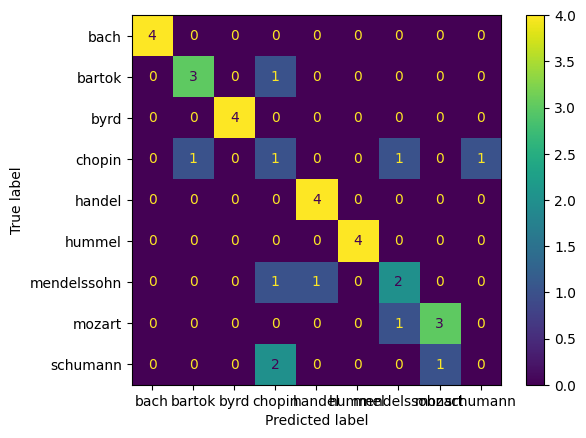

In [ ]:
#  generate confusion matrix

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


# Compute the confusion matrix
cm = confusion_matrix(test_y, predicted_indices)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)
disp.plot()
plt.show()

Approach 3: XGBoost model on the extracted features from raw midi files.

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
xgb_model = xgb.XGBClassifier(objective="softmax", eval_metric='mlogloss')

Training Accuracy: 100.00%
Testing Accuracy: 70.27%


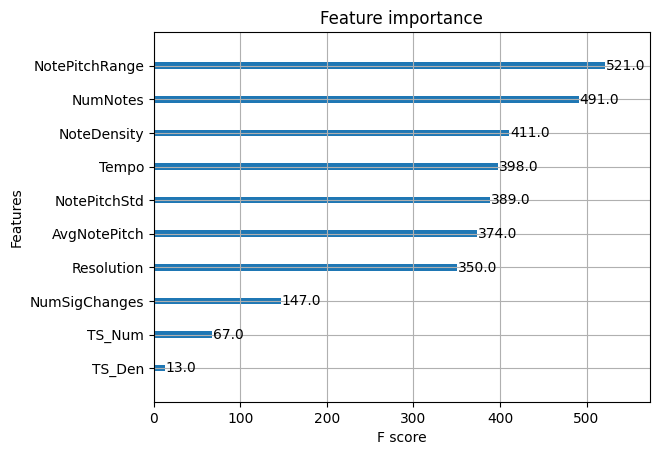

In [ ]:
# Loading the Dataset
file_path = '/content/train.csv'
data = pd.read_csv(file_path)

# Dropping the specified features
features_to_drop = ['NumInstruments']
data = data.drop(features_to_drop, axis=1)

# Encoding the Target Variable 'composer'
label_encoder = LabelEncoder()
data['composer'] = label_encoder.fit_transform(data['composer'])

# Splitting the Features and Target Variable
X = data.drop('composer', axis=1)
y = data['composer']

# Splitting the Data into Training and Testing Sets (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the XGBoost Model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective="softmax", eval_metric='mlogloss')

# Training the Model Using the Training Data
xgb_model.fit(X_train, y_train)

# Predicting the Labels for the Training and Testing Data
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Calculating the Accuracy of the Model on Training and Testing Sets
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Visualizing Feature Importance
xgb.plot_importance(xgb_model)
plt.show()

## Approach 4 : Extracting the Piano roll representation of each MIDI file and padding them with the median length of the audio files in the training dataset. And trained a stack of 1 convolution layer with 1 dense layer .

In [ ]:
import zipfile
from zipfile import *
import os
# Path to the new ZIP file containing the MIDI files
composer_zip_path = '/content/Composer_Dataset.zip'
# Extract path for the Composer Dataset
composer_extract_path = '/content/composer_dataset'

# Unzipping the provided Composer Dataset archive
with ZipFile(composer_zip_path, 'r') as zip_ref:
    zip_ref.extractall(composer_extract_path)

# Listing the contents of the extracted directory to understand the structure
composer_contents = os.listdir(composer_extract_path)
composer_contents


['Composer_Dataset', '__MACOSX']

In [ ]:
# Path to the Composer Dataset folder
composer_dataset_path = os.path.join(composer_extract_path, 'Composer_Dataset')

# Listing the contents of the Composer Dataset directory to identify the authors and MIDI files
composer_dataset_contents = os.listdir(composer_dataset_path)
composer_dataset_contents


['.DS_Store', 'NN_midi_files_extended']

In [ ]:
# Path to the directory that may contain the MIDI files
midi_files_extended_path = os.path.join(composer_dataset_path, 'NN_midi_files_extended')

# Listing the contents of the MIDI files extended directory
midi_files_extended_contents = os.listdir(midi_files_extended_path)
midi_files_extended_contents


['test', '.DS_Store', 'train', 'dev']

In [ ]:
# Path to the training directory
train_path = os.path.join(midi_files_extended_path, 'train')

# Listing the contents of the training directory to identify the authors and MIDI files
train_contents = os.listdir(train_path)
train_contents


['handel',
 'bach',
 'mozart',
 'mendelssohn',
 'chopin',
 '.DS_Store',
 'schumann',
 'hummel',
 'bartok',
 'byrd']

In [ ]:
from collections import defaultdict
import glob

def load_midi_files_and_labels(directory_path):

    midi_files = defaultdict(list)
    authors = [author for author in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, author))]

    for author in authors:
        author_path = os.path.join(directory_path, author)
        # Collecting all MIDI files for the given author
        author_midi_files = glob.glob(os.path.join(author_path, "*.mid"))
        # Storing MIDI files and corresponding labels
        midi_files[author] = author_midi_files

    return midi_files

# Load MIDI files and labels from the training directory
train_midi_files = load_midi_files_and_labels(train_path)
# Displaying the first 2 MIDI files for each author
{author: files[:2] for author, files in train_midi_files.items()}


{'handel': ['/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/handel/handel130.mid',
  '/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/handel/handel125.mid'],
 'bach': ['/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/bach/bach364.mid',
  '/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/bach/bach358.mid'],
 'mozart': ['/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/mozart/mozart000.mid',
  '/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/mozart/mozart002.mid'],
 'mendelssohn': ['/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/mendelssohn/mendelssohn246.mid',
  '/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/mendelssohn/mendelssohn278.mid'],
 'chopin': ['/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/chopin/chopin085.mid',
  '/content/composer_dataset/Composer_Dataset/NN_

In [ ]:
import pretty_midi
import numpy as np

def midi_to_piano_roll(midi_path, fs=10):
    """
    Convert a MIDI file to a piano roll representation.

    Args:
        midi_path (str): Path to the MIDI file.
        fs (int): Sampling frequency of the columns, i.e., each column is spaced apart by 1./fs seconds.

    Returns:
        piano_roll (np.ndarray): Piano roll representation of the MIDI file.
    """
    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    # Convert to piano roll
    piano_roll = midi_data.get_piano_roll(fs=fs)
    return piano_roll

def normalize_piano_roll(piano_roll):

    normalized_piano_roll = piano_roll / np.max(piano_roll)
    return normalized_piano_roll

# Example: Converting and normalizing the first MIDI file of the first author
example_midi_path = train_midi_files['schumann'][0]
example_piano_roll = midi_to_piano_roll(example_midi_path)
normalized_example_piano_roll = normalize_piano_roll(example_piano_roll)

# Displaying the shape of the normalized piano roll
normalized_example_piano_roll.shape

(128, 700)

In [ ]:
# Map author names to numerical labels
author_to_label = {author: i for i, author in enumerate(train_midi_files.keys())}


In [ ]:
# Convert and preprocess all MIDI files
X_train = []
y_train_labels = []
for author, midi_paths in train_midi_files.items():
    for midi_path in midi_paths:
        piano_roll = midi_to_piano_roll(midi_path)
        normalized_piano_roll = normalize_piano_roll(piano_roll)
        reshaped_piano_roll = normalized_piano_roll[np.newaxis, :, :]
        X_train.append(reshaped_piano_roll)
        y_train_labels.append(author_to_label[author])

In [ ]:
def pad_or_truncate_piano_roll(piano_roll, fixed_length):
    """Pad or truncate a piano roll to a fixed length."""
    original_shape = piano_roll.shape
    if piano_roll.shape[2] < fixed_length:
        padded_piano_roll = np.zeros((piano_roll.shape[0], piano_roll.shape[1], fixed_length))
        padded_piano_roll[:, :, :piano_roll.shape[2]] = piano_roll
        print(f"Padded: {original_shape} to {padded_piano_roll.shape}")
        return padded_piano_roll
    truncated_piano_roll = piano_roll[:, :, :fixed_length]
    print(f"Truncated: {original_shape} to {truncated_piano_roll.shape}")
    return truncated_piano_roll

# Determine the fixed length (e.g., using the median length)
fixed_length = int(np.median([piano_roll.shape[2] for piano_roll in X_train]))

# Pad or truncate piano rolls to the fixed length
X_train_fixed_length = [pad_or_truncate_piano_roll(piano_roll, fixed_length) for piano_roll in X_train]

# Check the shapes again
for piano_roll in X_train_fixed_length[:5]:
    print(piano_roll.shape)

In [ ]:
# Print the shapes of the original piano rolls
original_shapes = [piano_roll.shape for piano_roll in X_train]
print("Original shapes:", original_shapes)

# Print the shapes after padding or truncation
padded_or_truncated_shapes = [pad_or_truncate_piano_roll(piano_roll, fixed_length).shape for piano_roll in X_train]
print("Padded or truncated shapes:", padded_or_truncated_shapes)

In [ ]:
# Determine the fixed length (e.g., using the median length)
fixed_length = int(np.median([piano_roll.shape[1] for piano_roll in X_train]))

# Pad or truncate piano rolls to the fixed length
X_train_fixed_length = [pad_or_truncate_piano_roll(piano_roll, fixed_length) for piano_roll in X_train]

# Stack the piano rolls along a new axis to form a 4D array
X_train_reshaped = np.stack(X_train_fixed_length, axis=0)

# Add an additional dimension for the channel
X_train_reshaped = X_train_reshaped[:, np.newaxis, :, :]

# Check the shape
print(X_train_reshaped.shape)  # Should be (num_samples, 1, 128, fixed_length)

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_reshaped, y_train_labels, test_size=0.2, random_state=42
)


In [ ]:
# Pad or truncate piano rolls to the fixed length
X_train_fixed_length = [pad_or_truncate_piano_roll(piano_roll, fixed_length) for piano_roll in X_train]

# Reshape to include channel dimension and stack into a NumPy array
X_train_reshaped = np.array([piano_roll[np.newaxis, :, :] for piano_roll in X_train_fixed_length])

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_reshaped, y_train_labels, test_size=0.2, random_state=42
)

# Squeeze unnecessary dimensions
X_train_split = np.squeeze(X_train_split, axis=1)
X_val_split = np.squeeze(X_val_split, axis=1)

In [ ]:
# Stack the piano rolls along a new axis to form a 4D array
X_train_split = np.stack(X_train_split, axis=0)
X_val_split = np.stack(X_val_split, axis=0)
y_train_split = np.array(y_train_split)
y_val_split = np.array(y_val_split)

# Displaying the shapes of the training and validation sets
X_train_split.shape, X_val_split.shape, y_train_split.shape, y_val_split.shape


((295, 1, 128, 128), (74, 1, 128, 128), (295,), (74,))

In [ ]:
# Reshaping the piano rolls to remove the extra dimension
X_train_split = X_train_split.reshape(-1, 128, fixed_length, 1)
X_val_split = X_val_split.reshape(-1, 128, fixed_length, 1)


### Train the model

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler()

# Apply MinMax Scaling
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train_split.reshape(-1, 128 * fixed_length)).reshape(-1, 128, fixed_length, 1)
X_val_minmax = minmax_scaler.transform(X_val_split.reshape(-1, 128 * fixed_length)).reshape(-1, 128, fixed_length, 1)

# Apply Standard Scaling
standard_scaler = StandardScaler()
X_train_standardized = standard_scaler.fit_transform(X_train_split.reshape(-1, 128 * fixed_length)).reshape(-1, 128, fixed_length, 1)
X_val_standardized = standard_scaler.transform(X_val_split.reshape(-1, 128 * fixed_length)).reshape(-1, 128, fixed_length, 1)

NUM_CLASSES = len(train_midi_files.keys())
MAX_EPOCHS = 7
BATCH_SIZE = 164

model = Sequential([
    Conv2D(32, (3, 3), activation='gelu', input_shape=(128, fixed_length, 1)),
    Dropout(0.5),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='gelu'),
    Dropout(0.5),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='gelu', kernel_regularizer=l2(0.001)), # L2 regularization
    Dropout(0.5), # Dropout layer
    Dense(NUM_CLASSES, activation='sigmoid')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.fit(X_train_split, y_train_split, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_split, y_val_split))  # Updated to use split data

# Choose either MinMax scaling or Standardization for training
#X_train_preprocessed = X_train_minmax  # or X_train_standardized
#X_val_preprocessed = X_val_minmax  # or X_val_standardized

X_train_preprocessed = X_train_standardized
X_val_preprocessed = X_val_standardized

# Training the model
history = model.fit(X_train_preprocessed, y_train_split, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_preprocessed, y_val_split))


Epoch 1/7
2/2 [==============================] - 23s 10s/step - loss: 2.6637 - accuracy: 0.1153 - val_loss: 3.2695 - val_accuracy: 0.1622
Epoch 2/7
2/2 [==============================] - 18s 10s/step - loss: 2.2579 - accuracy: 0.2373 - val_loss: 2.8341 - val_accuracy: 0.1216
Epoch 3/7
2/2 [==============================] - 16s 8s/step - loss: 1.9800 - accuracy: 0.2712 - val_loss: 2.9429 - val_accuracy: 0.1757
Epoch 4/7
2/2 [==============================] - 16s 7s/step - loss: 1.8691 - accuracy: 0.3254 - val_loss: 3.0888 - val_accuracy: 0.2432
Epoch 5/7
2/2 [==============================] - 21s 10s/step - loss: 1.7566 - accuracy: 0.3627 - val_loss: 3.3433 - val_accuracy: 0.2432
Epoch 6/7
2/2 [==============================] - 16s 8s/step - loss: 1.7301 - accuracy: 0.3525 - val_loss: 3.6807 - val_accuracy: 0.2297
Epoch 7/7
2/2 [==============================] - 16s 7s/step - loss: 1.6334 - accuracy: 0.4203 - val_loss: 4.0484 - val_accuracy: 0.2432


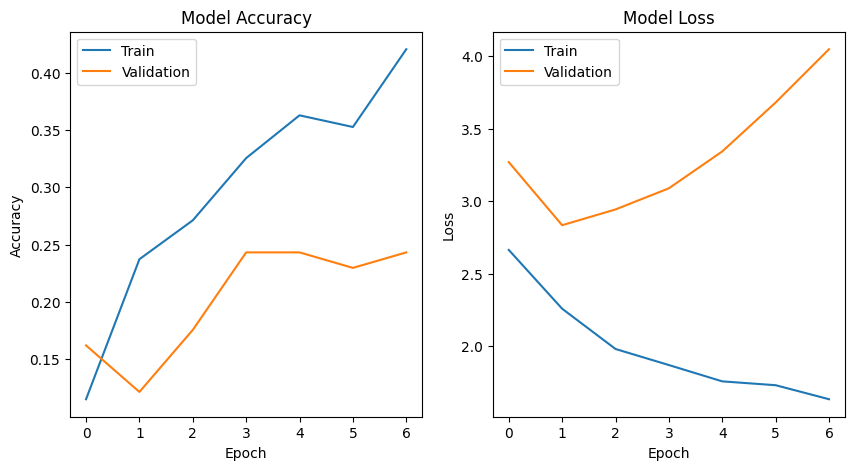

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=[10,5])
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Extracting the training and validation accuracy
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")

Final Training Accuracy: 42.03%
Final Validation Accuracy: 24.32%


# Approach 5 : Using pretrained model Wave2Vec model to have the feature embeddings for each audio file for all the classes to train a deep neural network to perform classification.

In [ ]:
import os
from midi2audio import FluidSynth

# Specify the input directory containing MIDI files
input_dir = '/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/'

# Specify the path to the downloaded SoundFont file
soundfont_path = '/content/salamander.sf2'

# Initialize FluidSynth with the specified SoundFont
fs = FluidSynth(soundfont_path)

# Convert each MIDI file to WAV and save in the same directory
for root, _, files in os.walk(input_dir):
    for file_name in files:
        if file_name.endswith(".midi") or file_name.endswith(".mid"):
            midi_path = os.path.join(root, file_name)
            wav_path = os.path.splitext(midi_path)[0] + ".wav"
            fs.midi_to_audio(midi_path, wav_path)
            print(f"Converted {midi_path} to WAV: {wav_path}")

print("Conversion complete.")


In [ ]:
from transformers import Wav2Vec2Model, Wav2Vec2CTCTokenizer
import numpy as np

# Load pretrained model and tokenizer
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
wave2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# Extract features using Wave2Vec
def extract_features(audio_input_values):
    input_values = tokenizer(audio_input_values, return_tensors="pt", padding="longest").input_values
    features = wave2vec_model(input_values).last_hidden_state
    return features.mean(dim=1).cpu().numpy()  # Take the mean over the sequence length


In [ ]:
%cd /content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train

In [ ]:
import os
import librosa
import numpy as np
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

# Constants
TARGET_SAMPLE_RATE = 16000
input_dir = '/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/'
MAX_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 9  # Adjust according to your specific classes

# Load pretrained model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wave2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

def preprocess_audio(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SAMPLE_RATE)
    return y_resampled

def prepare_data():
    X = []
    y = []
    composer_to_label = {
        "bach": 0,
        "bartok": 1,
        "byrd": 2,
        "chopin": 3,
        "handel": 4,
        "hummel": 5,
        "mendelssohn": 6,
        "mozart": 7,
        "schumann": 8,
    }

    for root, _, files in os.walk(input_dir):
        for file_name in files:
            if file_name.endswith(".wav"):
                audio_path = os.path.join(root, file_name)
                composer_name = os.path.basename(os.path.dirname(audio_path))
                label = composer_to_label[composer_name]
                audio_data = preprocess_audio(audio_path)
                input_values = processor(audio_data, return_tensors="pt", padding="longest").input_values
                features = wave2vec_model(input_values).last_hidden_state.squeeze().detach().numpy()
                X.append(features)
                y.append(label)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    return np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

X_train, X_val, y_train, y_val = prepare_data()

# Define the model
model = Sequential([
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


In [ ]:
import os
import librosa
import numpy as np
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

# Constants
TARGET_SAMPLE_RATE = 16000
input_dir = '/content/composer_dataset/Composer_Dataset/NN_midi_files_extended/train/'
MAX_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 9
DATA_FRACTION = 0.6  # Use only X% of the total dataset

# Load pretrained model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wave2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

def preprocess_audio(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SAMPLE_RATE)
    return y_resampled

def prepare_data():
    X = []
    y = []
    composer_to_label = {
        "bach": 0,
        "bartok": 1,
        "byrd": 2,
        "chopin": 3,
        "handel": 4,
        "hummel": 5,
        "mendelssohn": 6,
        "mozart": 7,
        "schumann": 8,
    }

    all_files = []
    for root, _, files in os.walk(input_dir):
        for file_name in files:
            if file_name.endswith(".wav"):
                all_files.append(os.path.join(root, file_name))

    # Select only a fraction of the data
    selected_files = np.random.choice(all_files, int(len(all_files) * DATA_FRACTION), replace=False)

    for audio_path in selected_files:
        composer_name = os.path.basename(os.path.dirname(audio_path))
        label = composer_to_label[composer_name]
        audio_data = preprocess_audio(audio_path)
        input_values = processor(audio_data, return_tensors="pt", padding="longest", sampling_rate=TARGET_SAMPLE_RATE).input_values
        features = wave2vec_model(input_values).last_hidden_state.squeeze().detach().numpy()
        X.append(features)
        y.append(label)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

    return np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

X_train, X_val, y_train, y_val = prepare_data()

# Define the model
model = Sequential([
    Flatten(),
    Dense(256, activation='gelu'),
    Dense(NUM_CLASSES, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Unfortunately, we do not have enough computational capabilities to complete this run.